# PRÁCTICA 3: Codificación de imágenes mediante DCT

In [2]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from scalib import UniformSQ, FixedLengthCoder, signalRange


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 1</h1>

<hr style="border: 1.5px solid orange;">

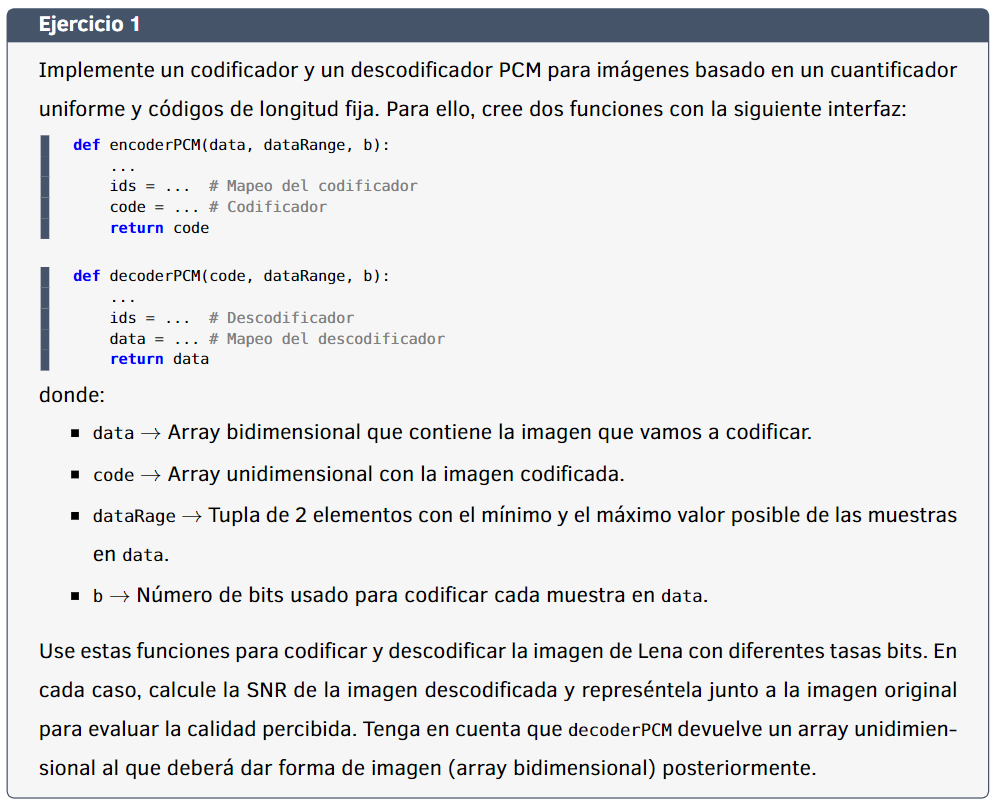

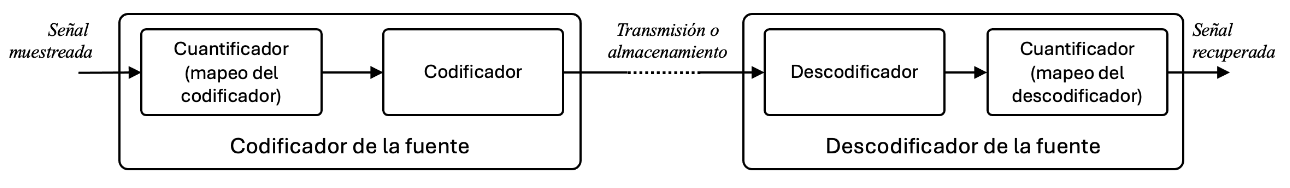

In [3]:
def encoderPCM(data, dataRange, b):
    """
    Codifica la imagen 'data' (2D) usando PCM:
    Devuelve:
        - code: array 1D de bits (0/1) empaquetados en bytes.
    """
    # 1) Mapeo del codificador: array de ids enteros [0, 2^b)
    qtz = UniformSQ(b, dataRange) # Crea un cuantificador de b bits (2^b niveles)
    ids = qtz.encode(data)        # Mapeo del codificador

    # 2) Codificador de longitud fija: ids → secuencia de bits
    coder = FixedLengthCoder(b)
    code = coder.encode(ids.flatten())
    
    return code


def decoderPCM(code, dataRange, b):
    """
    Descodifica la secuencia de bits 'code' con PCM:
    Devuelve:
        - data: array 1D de valores reconstruidos.
    """
    # 1) Descodificar bits → ids
    coder = FixedLengthCoder(b)  # Se crea un decodificador binario
    ids = coder.decode(code)     # agrupa los bits de b en b para obtener un entero por grupo.
                                 # code = [0,1,1,0,1,1]  # b = 2
                                 # → grupos: [01], [10], [11] → ids = [1, 2, 3]
    # 2) Mapeo del descodificador: ids → valores aproximados
    qtz = UniformSQ(b, dataRange)
    data = qtz.decode(ids)  # 1D array de floats
    
    return data

# data = [[50, 200], 
#        [100, 250]]   dataRange = (0, 256), b = 2 → 4 niveles

# Cuantificación:
# 50 → 0, 200 → 3, 100 → 1, 250 → 3
# → ids = [0, 3, 1, 3]

# Codificación (2 bits por id):
# 0 → 00, 3 → 11, 1 → 01, 3 → 11
# → code = [0,0, 1,1, 0,1, 1,1]

# Decodificación:
# [00]→0, [11]→3, [01]→1, [11]→3
# → ids = [0, 3, 1, 3]

# Reconstrucción (centros):
# 0→32.0, 3→224.0, 1→96.0
# → data ≈ [32.0, 224.0, 96.0, 224.0]


def calculate_snr(orig, recon):
    """
    SNR = 10 log10(var(orig) / var(orig - recon))
    """
    noise = orig - recon
    
    return 10 * np.log10(np.var(orig) / np.var(noise))

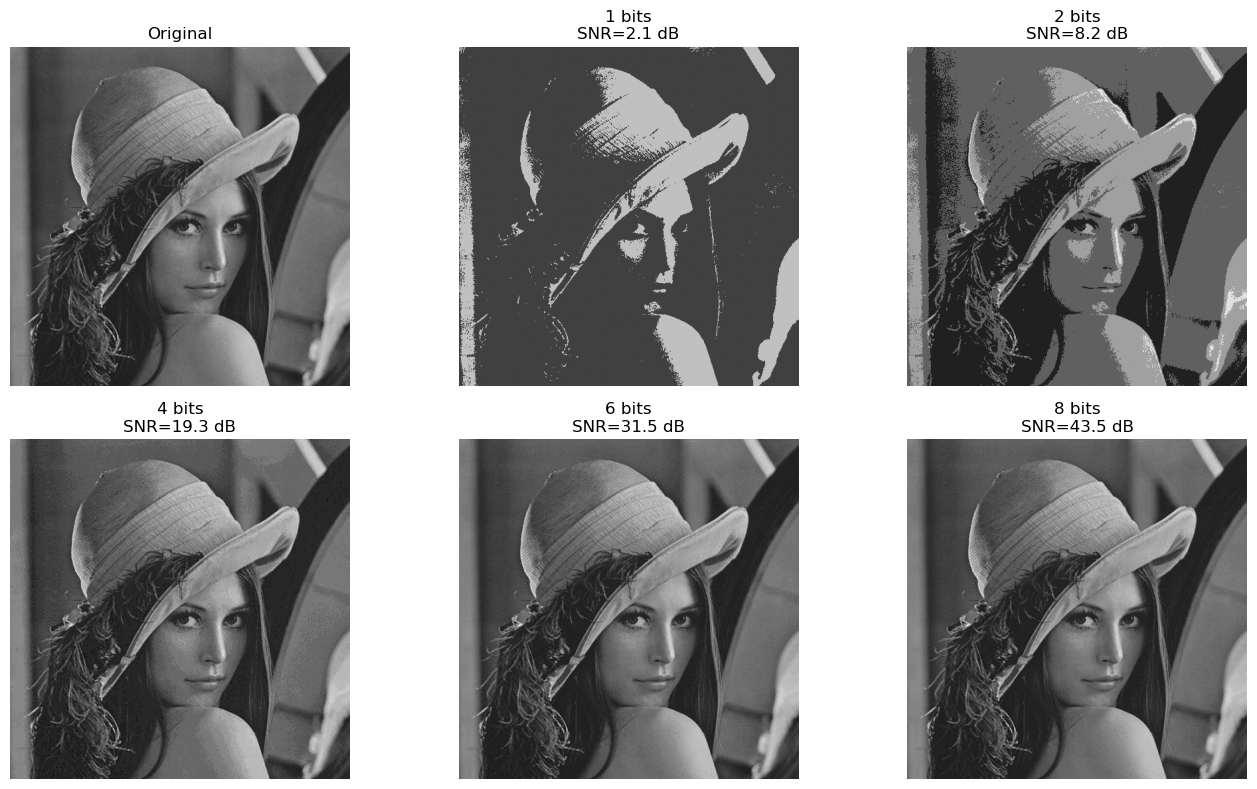

In [4]:
img_path = "Data/lena.png"  # Coloca lena.png en este directorio
bit_rates = [1, 2, 4, 6, 8]  # Tasas de bits a probar

#? 1) Leer imagen
im = img_as_float(io.imread(img_path, as_gray=True))
h, w = im.shape

dataRange = signalRange(im)  # (min, max) de la imagen 

#? 2) Codificar / Decodificar para cada tasa de bits
resultados = []

for b in bit_rates:
        code = encoderPCM(im, dataRange, b)   # Codificación PCM
        flat = decoderPCM(code, dataRange, b) # Decodificación PCM
        recon = flat.reshape((h, w))          # Reconstrucción 2D

        snr = calculate_snr(im, recon)        # Cálculo de SNR
        resultados.append((b, recon, snr))

#? 4) Visualizar original + reconstrucciones
n = len(resultados) + 1         # Número de imágenes a mostrar (original + reconstrucciones)
plt.figure(figsize=(14, 8))

plt.subplot(2, int(n/2), 1)     # Imagen original
plt.imshow(im, cmap="gray", vmin=0, vmax=1)
plt.title("Original")
plt.axis("off")

# Imágenes reconstruidas
for i, (b, recon, snr) in enumerate(resultados, start=2):
        plt.subplot(2, int(n/2), i)
        plt.imshow(recon, cmap="gray", vmin=0, vmax=1)
        plt.title(f"{b} bits\nSNR={snr:.1f} dB")
        plt.axis("off")

plt.tight_layout()
plt.show()



<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 2</h1>

<hr style="border: 1.5px solid orange;">

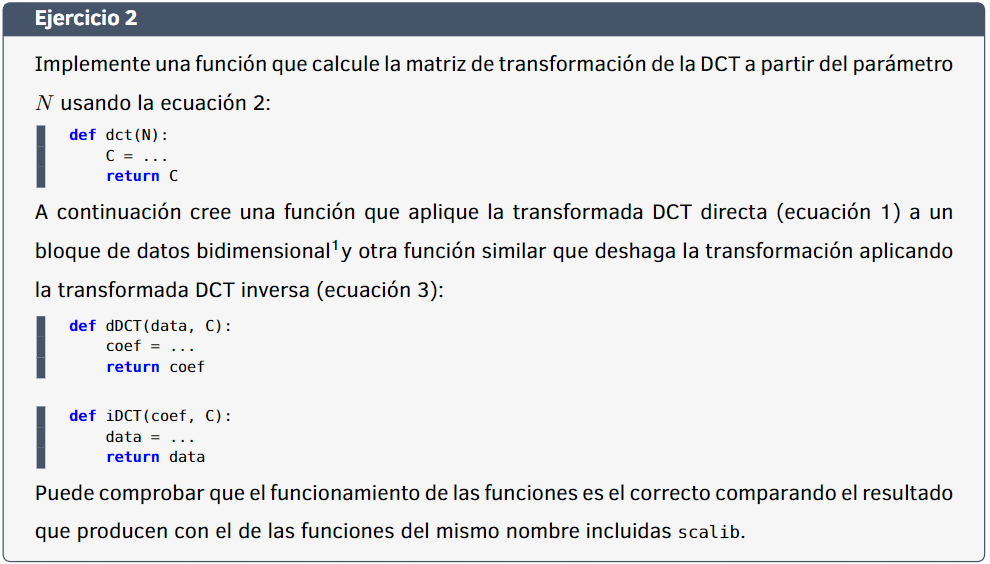

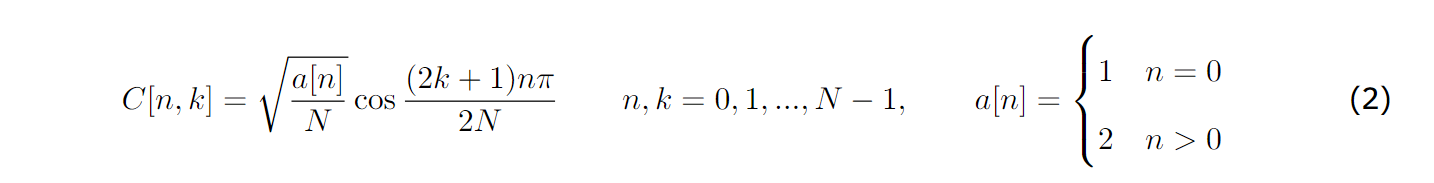

In [5]:
def dct(N):
    """
    Calcula la matriz de transformación DCT de tamaño N x N según la ecuación:
    C[n,k] = sqrt(a[n]/N) * cos((2*k + 1) * n * pi / (2*N)),    donde a[0] = 1, a[n>0] = 2.
    
    Parámetros:
        N : int                     -> Tamaño de la matriz (N x N).
        
    Devuelve:
        C : ndarray de forma (N, N) -> Matriz de transformación DCT.
    """
    
    a = np.full(N, 2.0)  # Inicializar a[n] = 2 para n > 0
    a[0] = 1.0           # a[0] = 1.0
    
    C = np.zeros((N, N), dtype=float)
    
    factor = np.pi / (2.0 * N) # cte
    
    for n in range(N):
        for k in range(N):
            C[n, k] = np.sqrt(a[n] / N) * np.cos((2 * k + 1) * n * factor)
    return C


def dDCT(block, C):
    """
    Aplica la DCT directa (bidimensional) a un bloque de datos usando la matriz C:
    Theta = C @ block @ C.T

    Parámetros:
        block : ndarray de forma (N, N)
        C : ndarray de forma (N, N)

    Devuelve:
        coef : ndarray de forma (N, N)
    """
    return C @ block @ C.T


def iDCT(coef, C):
    """
    Aplica la DCT inversa (bidimensional) a la matriz de coeficientes:
    block = C.T @ coef @ C

    Parámetros:
        coef : ndarray de forma (N, N)
        C : ndarray de forma (N, N)

    Devuelve:
        block : ndarray de forma (N, N)
    """
    return C.T @ coef @ C

Error coeficientes (vs scalib): 1.23e-26
Error reconstrucción (vs original): 9.71e-27


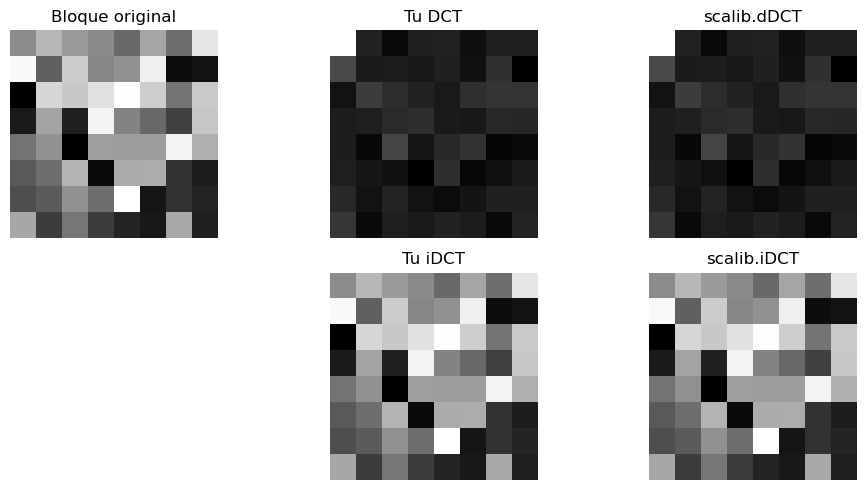

In [6]:

#!---------- Ejemplo práctico ----------
# Creamos un bloque de prueba (por ejemplo, imagen de 8x8)
np.random.seed(0)
N = 8
block = np.random.rand(N, N) * 255  # Bloque de 8x8 con valores entre 0 y 255


C = dct(N)
coef = dDCT(block, C)
recon = iDCT(coef, C)

# Comparación con funciones de scalib (scipy)
from scalib import dDCT, iDCT
import scalib as sc      

coef_ref = dDCT(block)
recon_ref = iDCT(coef)

# ---------- Métricas ----------
print(f"Error coeficientes (vs scalib): {sc.mse(coef, coef_ref):.2e}")
print(f"Error reconstrucción (vs original): {sc.mse(block, recon):.2e}")

# ---------- Visualización completa ----------
plt.figure(figsize=(10, 5))

# Bloque original
plt.subplot(2, 3, 1)
plt.imshow(block, cmap='gray')
plt.title("Bloque original")
plt.axis("off")
# Tus coeficientes
plt.subplot(2, 3, 2)
plt.imshow(coef, cmap='gray')
plt.title("Tu DCT")
plt.axis("off")
# Coeficientes referencia
plt.subplot(2, 3, 3)
plt.imshow(coef_ref, cmap='gray')
plt.title("scalib.dDCT")
plt.axis("off")
# Reconstrucción tuya
plt.subplot(2, 3, 5)
plt.imshow(recon, cmap='gray')
plt.title("Tu iDCT")
plt.axis("off")
# Reconstrucción referencia
plt.subplot(2, 3, 6)
plt.imshow(recon_ref, cmap='gray')
plt.title("scalib.iDCT")
plt.axis("off")

plt.tight_layout()
plt.show()

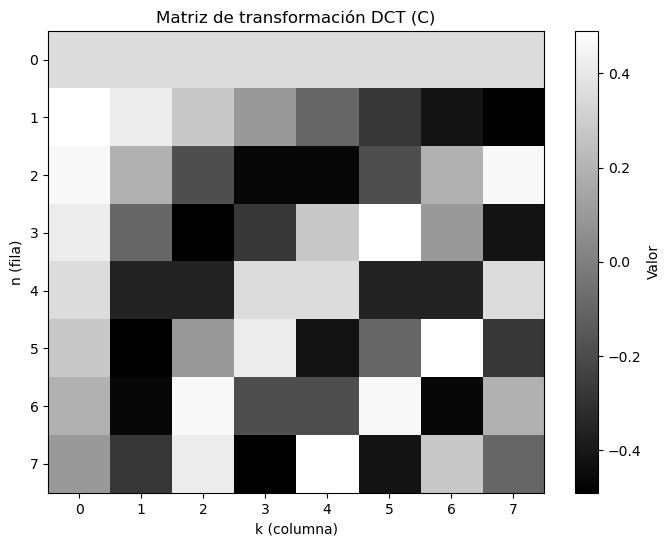

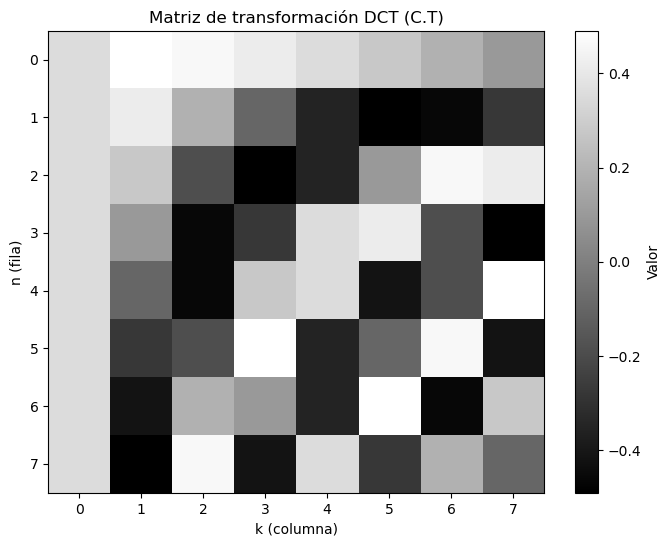

In [21]:
# Visualizar la matriz completa C
plt.figure(figsize=(8, 6))
plt.imshow(C, cmap='gray', aspect='auto')
plt.colorbar(label="Valor")
plt.title("Matriz de transformación DCT (C)")
plt.xlabel("k (columna)")
plt.ylabel("n (fila)")
plt.show()

# Visualizar la matriz completa C.T
plt.figure(figsize=(8, 6))
plt.imshow(C.T, cmap='gray', aspect='auto')
plt.colorbar(label="Valor")
plt.title("Matriz de transformación DCT (C.T)")
plt.xlabel("k (columna)")
plt.ylabel("n (fila)")
plt.show()

<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 3 & 4</h1>

<hr style="border: 1.5px solid orange;">

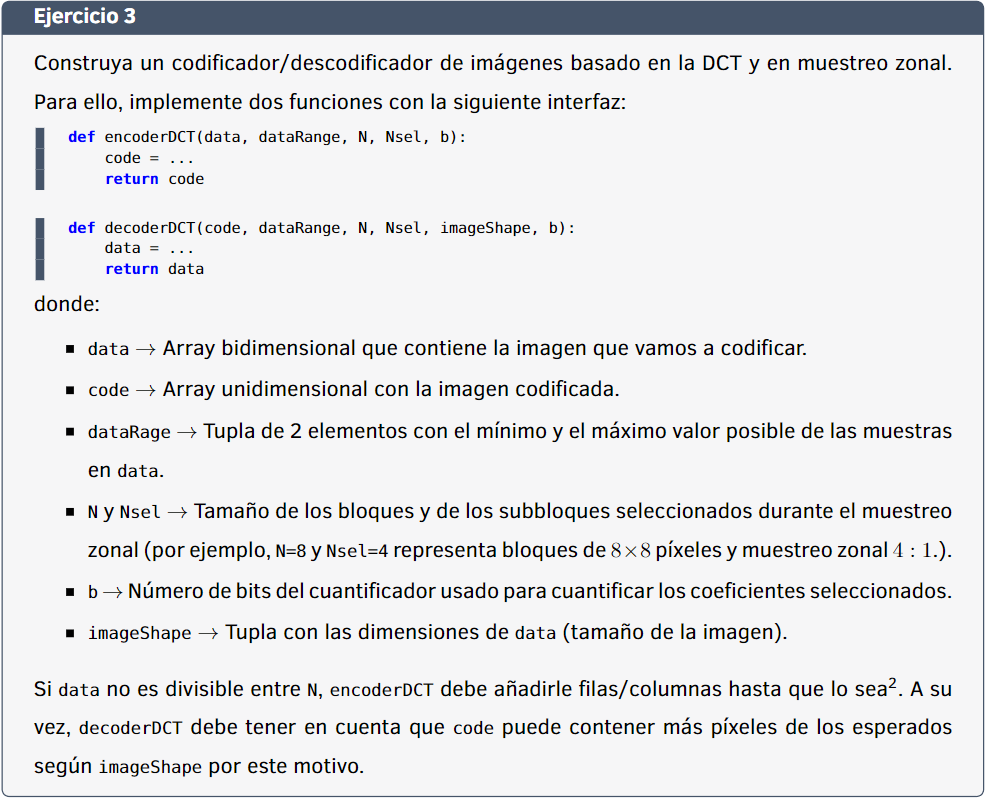

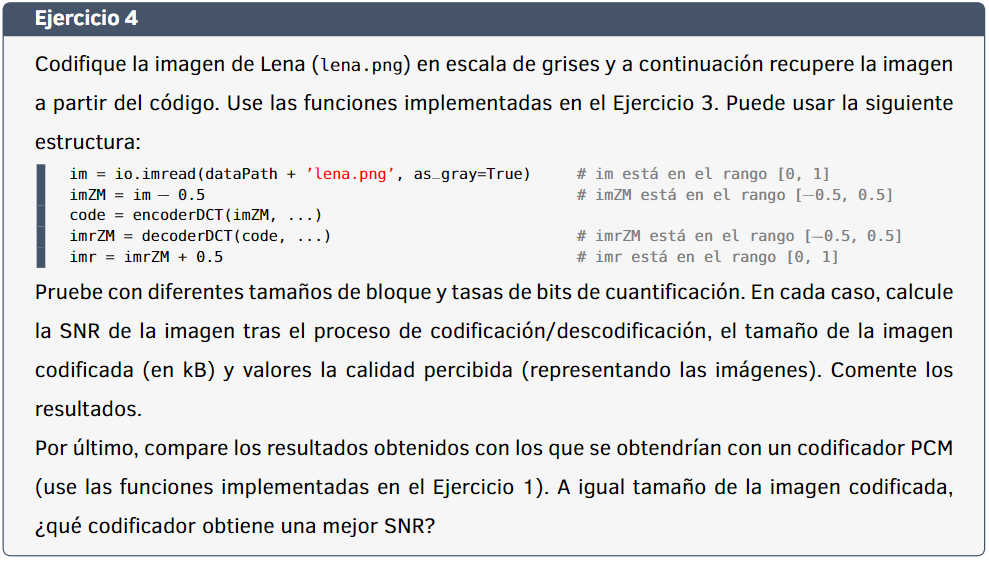

In [22]:
def encoderDCT(data, dataRange, N, Nsel, b):
    """
    Codifica la imagen 'data' (2D) con DCT + muestreo zonal:
      - dataRange = (mín, máx) rango de píxeles de 'data'
      - N = tamaño de bloque
      - Nsel = tamaño de la submatriz de coeficientes (zonales)
      - b = bits de cuantificación

    Devuelve:
      code : array 1D con la secuencia de bits codificados.
    """
    h, w = data.shape
    # Añadir ceros para que data sea múltiplo de N
    pad_h = (N - h % N) % N  
    pad_w = (N - w % N) % N  # h % N → cuántas filas sobran
                             # N - (h % N) → cuántas filas faltan para llegar al siguiente múltiplo de N
                             # N final evita que pad sea igual a N cuando h ya es múltiplo
    padded = np.pad(data, ((0, pad_h), (0, pad_w)), mode="constant")

    C = dct(N)
    coeffs = []

    for i in range(0, padded.shape[0], N):
        for j in range(0, padded.shape[1], N):
            block = padded[i : i + N, j : j + N]
            theta = dDCT(block, C)
            coeffs.append(theta[:Nsel, :Nsel].ravel()) # Toma solo los coeficientes en la esquina superior izquierda de la DCT. 
                                                       # Son las frecuencias más bajas, las que más aportan a la apariencia visual 
                                                       # general del bloque.
    coeffs = np.hstack(coeffs)  

    # Por último, cuantificar y codificar
    qtz = UniformSQ(b, dataRange)
    ids = qtz.encode(coeffs)
    coder = FixedLengthCoder(b)
    code = coder.encode(ids)
    
    return code


def decoderDCT(code, dataRange, N, Nsel, imageShape, b):
    """
    Decodifica la secuencia 'code' producida por encoderDCT:
      - dataRange, N, Nsel, b igual que en encoder
      - imageShape = (alto, ancho) original de la imagen

    Devuelve:
      data : array 2D reconstruido en el rango original.
    """
    
    # Decodificar bits y descuantificar
    coder = FixedLengthCoder(b)
    ids = coder.decode(code)
    qtz = UniformSQ(b, dataRange)
    coeffs = qtz.decode(ids)

    # Número de bloques         
    blocks_h = (imageShape[0] + N - 1) // N # como ceil(imageShape[0] / N)
    blocks_w = (imageShape[1] + N - 1) // N
    total = blocks_h * blocks_w
    coeffs = coeffs.reshape((total, Nsel, Nsel))

    C = dct(N)
    padded_h = blocks_h * N
    padded_w = blocks_w * N
    recon = np.zeros((padded_h, padded_w))

    idx = 0
    for i in range(0, padded_h, N):
        for j in range(0, padded_w, N):
            theta = np.zeros((N, N))
            theta[:Nsel, :Nsel] = coeffs[idx]
            block = iDCT(theta, C)
            recon[i : i + N, j : j + N] = block
            idx += 1

    # Recortar al tamaño original
    return recon[: imageShape[0], : imageShape[1]]


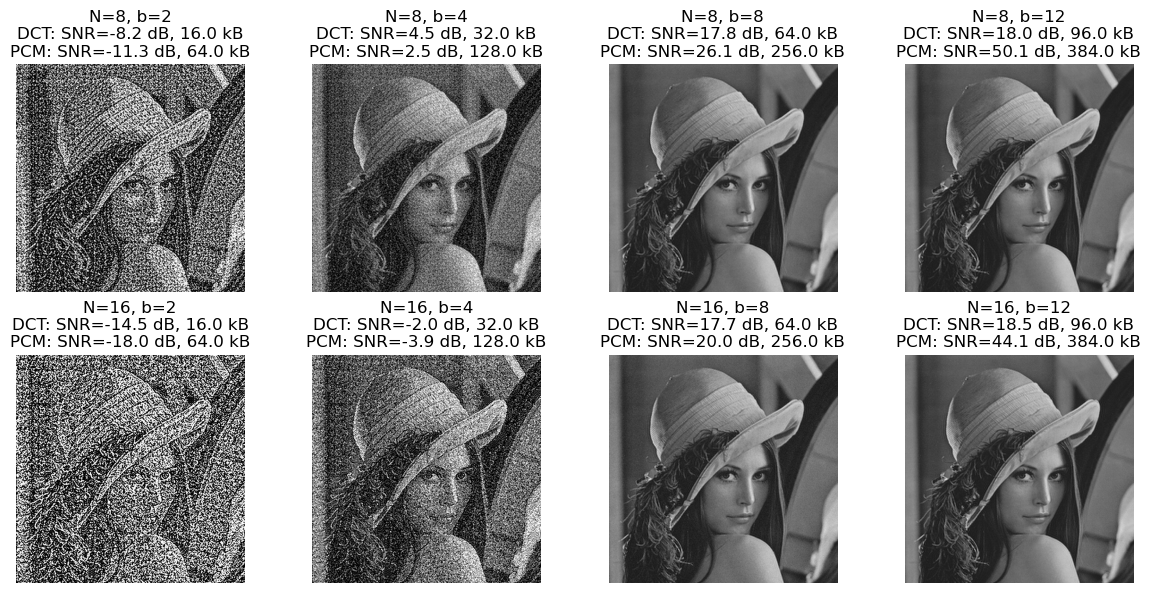

In [ ]:
# * --- 1) Cargar imagen y preprocesar ---
im = img_as_float(io.imread("Data/lena.png", as_gray=True))   # Imagen original en [0,1]
im0 = im - 0.5                                                # Centramos a [-0.5, +0.5]
shape = im0.shape
max_val_global = np.max(np.abs(im0))                    # Máximo valor absoluto

# --- 2) Parámetros de compresión a probar ---
bloque_sizes = [8, 16]                                  # Tamaños de bloque DCT
bit_rates = [2, 4, 8, 12]                                   # Bits por muestra

# --- 3) Crear figura para visualización ---
fig, axes = plt.subplots(
    len(bloque_sizes), len(bit_rates),
    figsize=(3 * len(bit_rates), 3 * len(bloque_sizes))
)
plt.gray()  # Escala de grises

# --- 4) Evaluar todas las combinaciones (bloque × bits) ---
for i, N in enumerate(bloque_sizes):
    # Rango dinámico adaptado: más N → mayor amplitud esperada
    data_range = (-N * max_val_global, N * max_val_global)
    Nsel = N // 2  # Muestreo zonal: solo N/2 × N/2 coeficientes

    for j, b in enumerate(bit_rates):
        # aplicar DCT con zonal y cuantificación
        code_dct = encoderDCT(im0, data_range, N, Nsel, b)
        rec_dct = decoderDCT(code_dct, data_range, N, Nsel, shape, b) + 0.5

        snr_dct = calculate_snr(im, rec_dct)
        size_dct = len(code_dct) / 8 / 1024  # kB

        # comparación con PCM uniforme puro
        code_pcm = encoderPCM(im0, data_range, b)
        rec_pcm = decoderPCM(code_pcm, data_range, b).reshape(shape) + 0.5

        snr_pcm = calculate_snr(im, rec_pcm)
        size_pcm = len(code_pcm) / 8 / 1024  # kB

        # Mostrar reconstrucción con DCT en la cuadrícula
        ax = axes[i, j]
        ax.imshow(rec_dct, vmin=0, vmax=1)
        ax.set_title(
            f"N={N}, b={b}\n"
            f"DCT: SNR={snr_dct:.1f} dB, {size_dct:.1f} kB\n"
            f"PCM: SNR={snr_pcm:.1f} dB, {size_pcm:.1f} kB"
        )
        ax.axis("off")

plt.tight_layout()
plt.show()


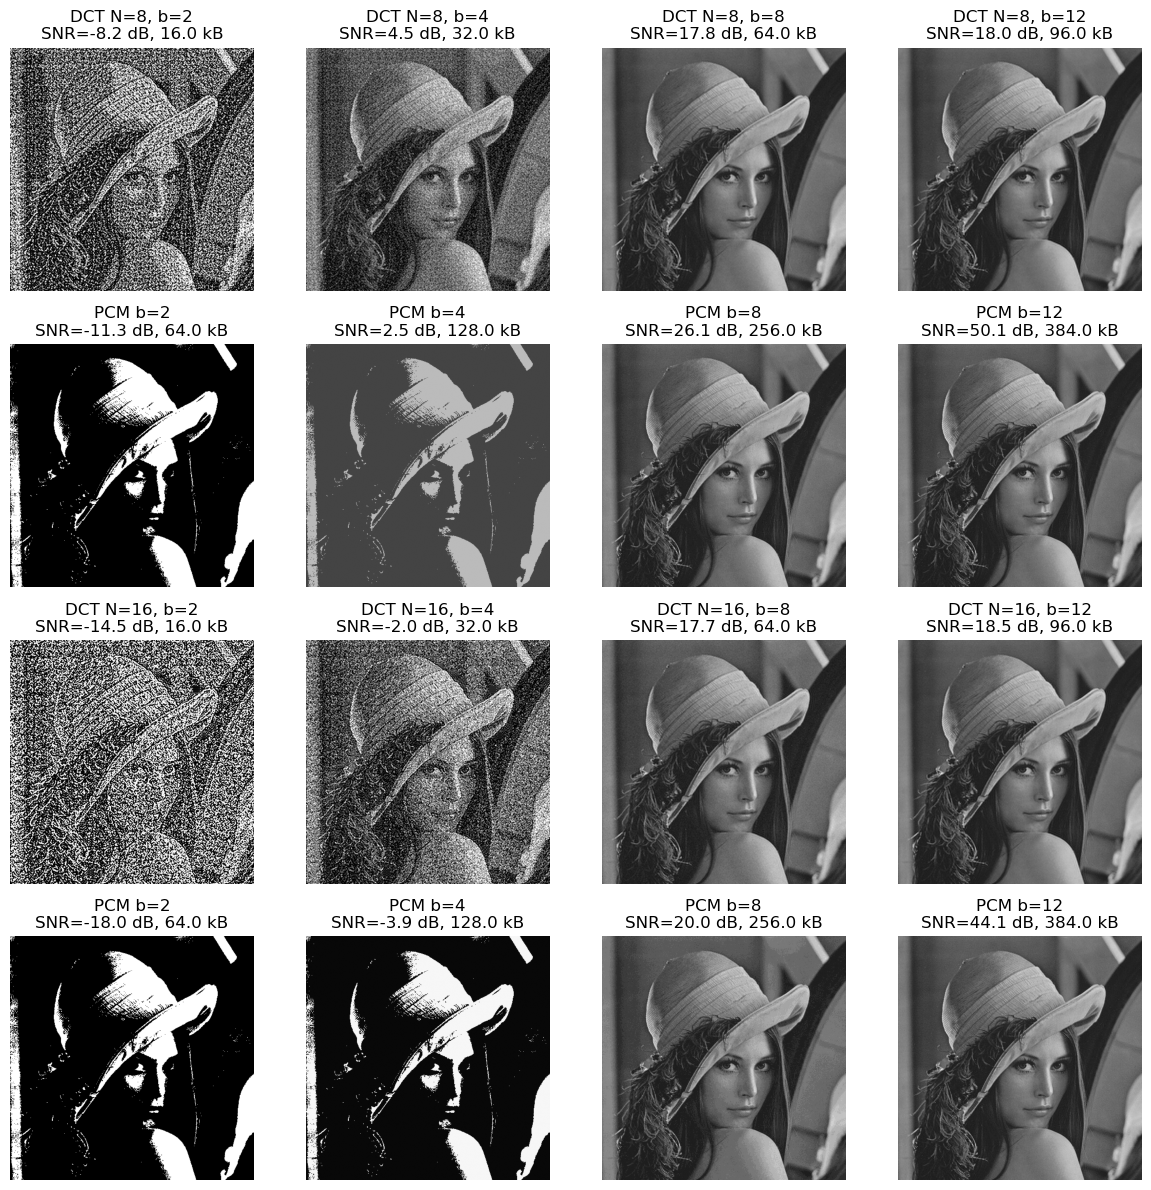

In [23]:
# Cargar imagen y preprocesar
im = img_as_float(io.imread("Data/lena.png", as_gray=True))
im0 = im - 0.5
shape = im0.shape
max_val_global = np.max(np.abs(im0))

# Parámetros a probar
bloque_sizes = [8, 16]
bit_rates = [2, 4, 8, 12]

# Crear figura: ahora con 2 filas por cada combinación
fig, axes = plt.subplots(
    2 * len(bloque_sizes), len(bit_rates),
    figsize=(3 * len(bit_rates), 6 * len(bloque_sizes))
)
plt.gray()

# Evaluar combinaciones
for i, N in enumerate(bloque_sizes):
    data_range = (-N * max_val_global, N * max_val_global)
    Nsel = N // 2

    for j, b in enumerate(bit_rates):
        # DCT
        code_dct = encoderDCT(im0, data_range, N, Nsel, b)
        rec_dct = decoderDCT(code_dct, data_range, N, Nsel, shape, b) + 0.5
        snr_dct = calculate_snr(im, rec_dct)
        size_dct = len(code_dct) / 8 / 1024  # en kB

        # PCM
        code_pcm = encoderPCM(im0, data_range, b)
        rec_pcm = decoderPCM(code_pcm, data_range, b).reshape(shape) + 0.5
        snr_pcm = calculate_snr(im, rec_pcm)
        size_pcm = len(code_pcm) / 8 / 1024  # en kB

        # Mostrar DCT
        ax_dct = axes[2 * i, j]
        ax_dct.imshow(rec_dct, vmin=0, vmax=1)
        ax_dct.set_title(
            f"DCT N={N}, b={b}\nSNR={snr_dct:.1f} dB, {size_dct:.1f} kB"
        )
        ax_dct.axis("off")

        # Mostrar PCM debajo
        ax_pcm = axes[2 * i + 1, j]
        ax_pcm.imshow(rec_pcm, vmin=0, vmax=1)
        ax_pcm.set_title(
            f"PCM b={b}\nSNR={snr_pcm:.1f} dB, {size_pcm:.1f} kB"
        )
        ax_pcm.axis("off")

plt.tight_layout()
plt.show()